# Удаление фона с помощью SVD

In [ ]:
%pip install -q moviepy==1.0.3
%pip install -q ffmpeg

In [ ]:
import moviepy.editor as mpe
from google.colab import drive

video = mpe.VideoFileClip("data/SVD_video_1.mp4")
'''
Я запускал так, потому что возникала проблема с запуском по образцу

drive.mount('/content/drive')
video = mpe.VideoFileClip("/content/drive/MyDrive/Colab Notebooks/SVD_video_1.mp4"
)
'''
video.ipython_display(width=300, maxduration=250)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_w, size_h = video.size
    arr = np.zeros([nframes, size_h, size_w])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 80 x 60, 
number of frames: 2883


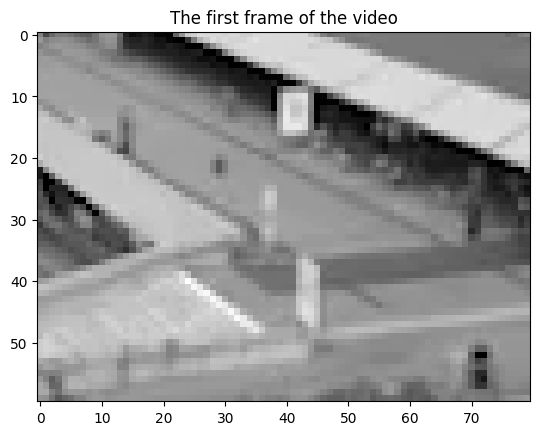

In [ ]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');


1. При помощи функции *np.reshape()* из трёхммерного массива arr получаем двумерный M размерами (size_h*size_w) x nframes. Каждый столбец массива - изображение.

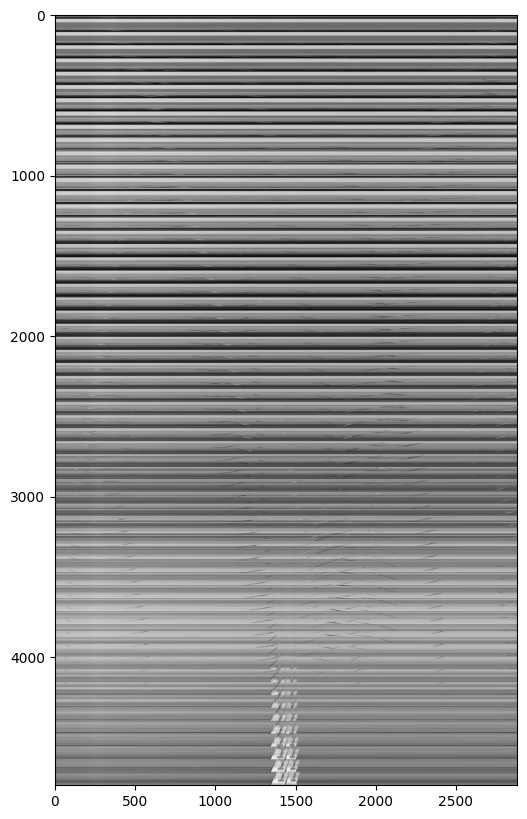

In [ ]:
nframes, size_h, size_w = arr.shape
M = arr.reshape(nframes, size_h * size_w).T

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

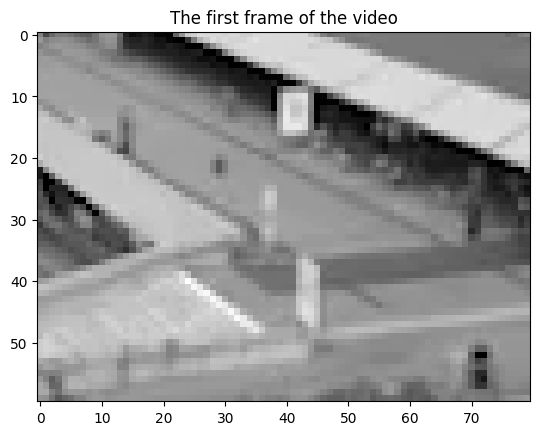

In [ ]:
first_frame = M[:,0].reshape(size_h, size_w)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

Вычисление сингулярного разложения

---


Первое сингулярное число (для видео) отвечает "помещение", всё, что не двигается.
Сингулярные числа, близкие к нулю, отвечают за изменения в видео (кадрах). Это могут быть движения людей, помехи камеры и т.д.

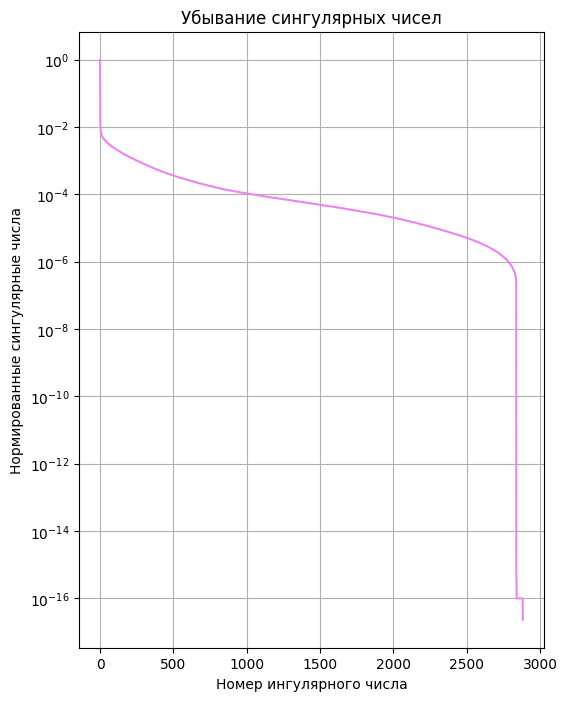

'\nПервое сингулярное число (для видео) отвечает "помещение", всё, что не двигается.\nСингулярные числа, близкие к нулю, отвечают за изменения в видео (кадрах). Это могут быть движения людей, помехи камеры и т.д.\n'

In [ ]:
U, S, Vt =np.linalg.svd(M,full_matrices=False)

plt.figure(figsize=(6,8))
plt.semilogy(S /S[0], color="violet")
plt.ylabel("Нормированные сингулярные числа")
plt.xlabel("Номер ингулярного числа")
plt.title("Убывание сингулярных чисел")
plt.grid()
plt.show()


Оптимальное приближение усечённого SVD (находим погрешность)

In [ ]:
def trunc_svd(M, r):
    Ur= U[:,:r]
    Sr = S[:r]
    Vtr = Vt[:r, :]
    # символ @ - перемножение по правилам матриц
    Mr= Ur @ np.diag(Sr)@ Vtr
    rel_eps = np.sqrt(np.sum(S**2) -np.sum(S[0:r]) / np.sum(S**2))
    return Mr, rel_eps

4.    Построение при помощи усечённого, полного SVD:
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [ ]:
M_svd, rel_error = trunc_svd(M, 1)

first_frame = M[:,0].reshape(size_h, size_w)
first_frame_svd = M_svd[:, 0].reshape(size_h, size_w)
first_frame_people = first_frame -first_frame_svd

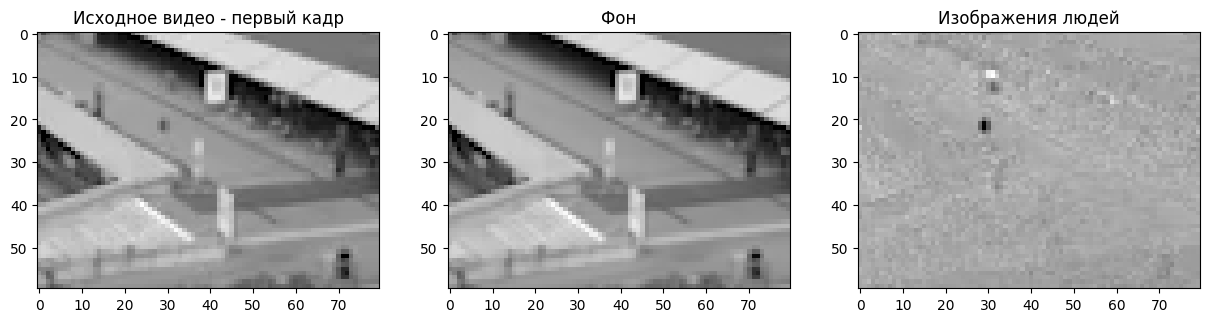

In [ ]:
_, axs =plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame,cmap='gray')
axs[0].set_title("Исходное видео - первый кадр")
axs[1].imshow(first_frame_svd, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(first_frame_people, cmap='gray')
axs[2].set_title("Изображения людей");

### Применение рандомизированного алгоритма SVD

Загрузим теперь видео в более высоком разрешении.

In [ ]:
import moviepy.editor as mpe
from google.colab import drive
drive.mount('/content/drive')

video3 = mpe.VideoFileClip("/content/drive/MyDrive/Colab Notebooks/SVD_video_2.mp4"
)
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 80 x 60, 
number of frames: 2883


In [ ]:
arr3 = video_to_array(video3)
nframes, size_h, size_w = arr3.shape
M3 = arr.reshape(nframes,size_h * size_w).T

image size: 80 x 60, 
number of frames: 2883


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

Реализация рандомизированного SVD с параметром r (ранг). Алгоритм запускается с (r + oversampling ) случайных векторов, после чего ранг обрезается до r с наименьшей ошибкой.

In [ ]:
def rand_svd(M, r,oversampling=10):
  m, n = M.shape
  Omega = np.random.randn(n,r + oversampling)
  Y = M @ Omega
  Q, _= np.linalg.qr(Y)
  B = Q.T@ M
  U_B, S_B, Vt_B = np.linalg.svd(B,full_matrices=False)

  U_r =U_B[:, :r]
  S_r = np.diag(S_B[:r])
  Vt_r = Vt_B[:r, :]

  Mr =Q@ U_r @ S_r@ Vt_r
  rel_eps = np.linalg.norm(M - Mr, 'fro') /np.linalg.norm(M, 'fro')

  return Mr, rel_eps

2. Используя ```rand_svd```, найдём наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. Построим изображения первого кадра.
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [ ]:
M_rand, errors = rand_svd(M3, 1)
first_frame = M3[:, 0].reshape(size_h, size_w)
first_frame_rand = M_rand[:, 0].reshape(size_h, size_w)
first_frame_people = first_frame - first_frame_rand


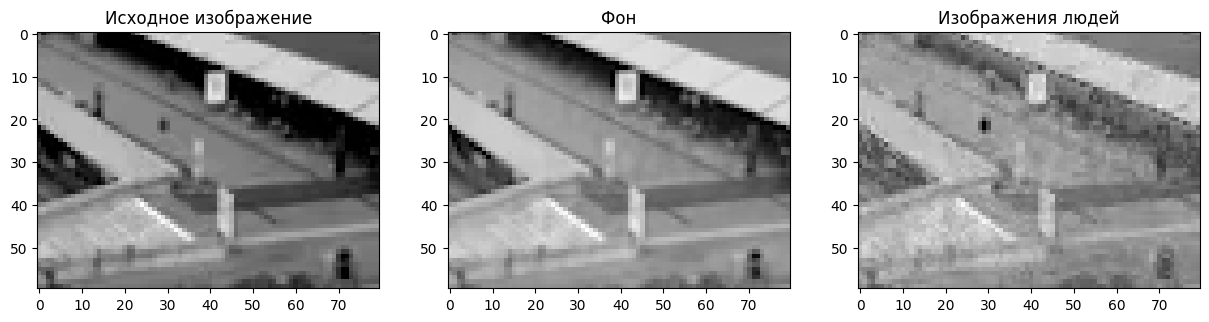

In [ ]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(first_frame_rand, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(first_frame_people, cmap='gray')
axs[2].set_title("Изображения людей");

# Из-за того, что ранг приближённой матрицы равен 1, используется лишь 1 сингулярное число, из-за этого выделение людей происходит неэффективно


3. Построение графика функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выбираем сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредним результат, запустив алгоритм 10 раз.


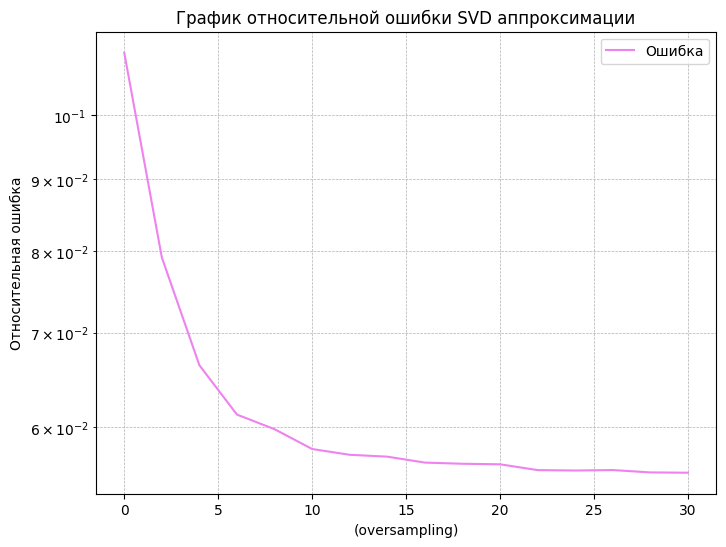

In [ ]:
def compute_relative_error(M, r, p, num_trials=10):
    errors = []

    for i in p:
        rel_errors = []
        for _ in range(num_trials):
            M_rand, rel_eps = rand_svd(M, r, i)
            rel_errors.append(rel_eps)

        errors.append(np.mean(rel_errors))

    return errors

p = np.arange(0, 31, 2)
errors = compute_relative_error(M3, r=2, p=p, num_trials=10)

plt.figure(figsize=(8, 6))
plt.plot(p, errors, color='violet', label='Ошибка')
plt.yscale('log')
plt.xlabel('(oversampling)')
plt.ylabel('Относительная ошибка')
plt.title('График относительной ошибки SVD аппроксимации')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти.

### c. Видео с переменным освещением

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [ ]:
from google.colab import drive
import moviepy.editor as mpe
'''
Я зкпускал так, потому что возникала проблема с запуском по образцу
drive.mount('/content/drive')

video2 = mpe.VideoFileClip("/content/drive/MyDrive/Colab Notebooks/SVD_video_2.mp4"
)
'''
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")

video2.ipython_display(width=300, maxduration=250)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
arr2 = video_to_array(video2)

image size: 80 x 60, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [ ]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Получим из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

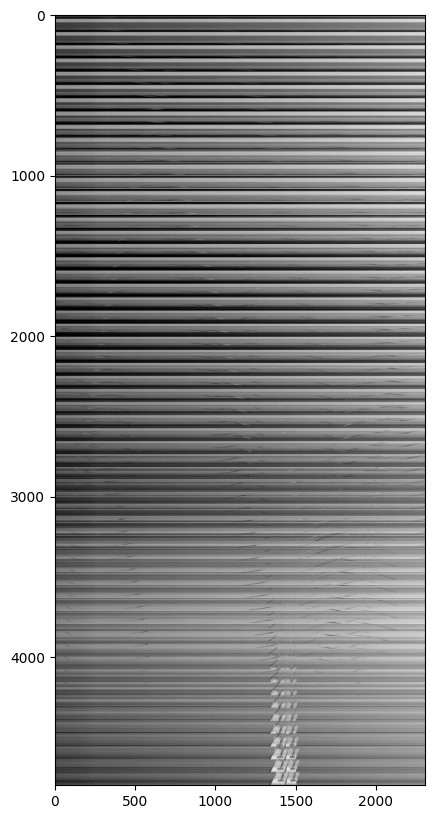

In [ ]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape(nframes2, size_h*size_w).T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. Применим полное SVD и усечённое для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравним время работы алгоритмов.

In [ ]:
import time
start = time.time()
r = 2

U1, S1, Vt1 = np.linalg.svd(M, full_matrices=False)
time_svd_1 = time.time() - start

Ur1 = U1[:, :r]
Sr1 = S1[:r]
Vtr1 = Vt1[:r, :]
M_rand,_ = rand_svd(M,r)
M1_svd = Ur1 @ np.diag(Sr1) @ Vtr1
rel_error_svd_M = np.linalg.norm(M - M1_svd, ord='fro')/ np.linalg.norm(M, ord='fro')
rel_error_rand = np.linalg.norm(M - M_rand, ord='fro')/ np.linalg.norm(M, ord='fro')

start = time.time()
_, rel_eps_rand_1 = rand_svd(M, r)
time_rand_1 = time.time() - start

start = time.time()
U2, S2, Vt2 = np.linalg.svd(M2, full_matrices=False)
time_svd_2 = time.time() - start

start = time.time()
M2_rand,_ = rand_svd(M2,r)
time_rand_2 = time.time() - start

Ur2 = U2[:, :r]
Sr2 = S2[:r]
Vtr2 = Vt2[:r, :]
M2_rand, rel_error_svd_M2 = rand_svd(M2, r)
M2_svd = Ur2 @ np.diag(Sr2) @ Vtr2
rel_error_rand_M2 = np.linalg.norm(M2 - M2_rand, ord='fro') / np.linalg.norm(M, ord='fro')

print(f"Полное SVD для матрицы M1: {time_svd_1:.4f} сек")
print(f"Рандомизированное SVD для матрицы M1: {time_rand_1:.4f} сек")
print(f"Полное SVD для матрицы M2: {time_svd_2:.4f} сек")
print(f"Рандомизированное SVD для матрицы M2: {time_rand_2:.4f} сек")
print("По результам видно, насколько быстрее работает рандомизированное SVD в сравнении с полным SVD")


Полное SVD для матрицы M1: 61.1242 сек
Рандомизированное SVD для матрицы M1: 0.6477 сек
Полное SVD для матрицы M2: 30.6804 сек
Рандомизированное SVD для матрицы M2: 0.4706 сек
По результам видно, насколько быстрее работает рандомизированное SVD в сравнении с полным SVD


3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [ ]:
print(f"Постоянное освещение (SVD): {rel_error_svd_M:.4f}")
print(f"Постоянное освещение (Rand SVD): {rel_error_rand:.4f}")
print(f"Переменное освещение (SVD): {rel_error_svd_M2:.4f}")
print(f"Переменное освещение (Rand SVD): {rel_error_rand_M2:.4f}")

Постоянное освещение (SVD): 0.0469
Постоянное освещение (Rand SVD): 0.0524
Переменное освещение (SVD): 0.0651
Переменное освещение (Rand SVD): 0.0547
Из результатов видно, что полное SVD дает меньшую относительную ошибку для матрицы M и видео с постоянным освещением по сравнению с рандомизированным SVD, что подтверждает эффективность полного SVD в таких задачах. Рандомизированный SVD показывает чуть большую ошибку, но при этом также предоставляет приемлемые результаты с точки зрения вычислительных затрат.


Из результатов видно, что полное SVD дает меньшую относительную ошибку для матрицы M и видео с постоянным освещением по сравнению с рандомизированным SVD, что подтверждает эффективность полного SVD в таких задачах. Рандомизированный SVD показывает чуть большую ошибку, но при этом также предоставляет приемлемые результаты с точки зрения вычислительных затрат.


4. Преобразующем матрицу типа ```M2``` обратно в видео.

In [ ]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.T.reshape(nframes, size_h, size_w)
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)


Посмотрим, как выглядит предлагаемое приближение.

In [ ]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
